# Проект: классификация

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 1. Знакомство с данными, обработка пропусков и выбросов

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<p style = "background-color : #afeeee; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Импортируем библиотеки используемые в работе:</span>

In [193]:
# Расчёты
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Обучение, опитимизация, метрики
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import linear_model,tree, ensemble, metrics, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import optuna
import optuna.visualization as vis

# Подавления сообщений об ошибках 
import warnings
warnings.filterwarnings('ignore')

# Для распечатки в цвете:
from termcolor import colored

# Для рандома цветов
import random

# Учет времени обучения
import time

# Чтобы графики отображались в github
from IPython.display import Image, display


In [194]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

<div class="alert alert-info">
    
 Оценим, насколько предложенные данные готовы к дальнейшему анализу

In [195]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<div class="alert alert-info">

- <span style="color:#191970">**age**</span> -  (возраст);
- <span style="color:#191970">**job**</span> - (сфера занятости);
- <span style="color:#191970">**marital**</span> - (семейное положение);
- <span style="color:#191970">**education**</span> - (уровень образования);
- <span style="color:#191970">**default**</span> - (имеется ли просроченный кредит);
- <span style="color:#191970">**housing**</span> - (имеется ли кредит на жильё);
- <span style="color:#191970">**loan**</span> - (имеется ли кредит на личные нужды);
- <span style="color:#191970">**balance**</span> - (баланс).
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- <span style="color:#191970">**contact**</span> - (тип контакта с клиентом);
- <span style="color:#191970">**month**</span> - (месяц, в котором был последний контакт);
- <span style="color:#191970">**day**</span> - (день, в который был последний контакт);
- <span style="color:#191970">**duration**</span> - (продолжительность контакта в секундах).
Прочие признаки:

- <span style="color:#191970">**campaign**</span> - (количество контактов с этим клиентом в течение текущей кампании);
- <span style="color:#191970">**pdays**</span> - (количество пропущенных дней с момента последней маркетинговой кампании до контакта - <span style="color:#191970">**в текущей кампании);
- <span style="color:#191970">**previous**</span> - (количество контактов до текущей кампании)
- <span style="color:#191970">**poutcome**</span> - (результат прошлой маркетинговой кампании).
- <span style="color:#191970">**deposit**</span> - **(целевая переменная , которая определяет, согласится ли клиент открыть депозит в банке)**

In [196]:
# исследуйем данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
print(colored('Смотрим типы данных и наличие пропусков:\n', 'blue'))
df.info()
print(colored(f'\n- Количество столбцов:{df.shape[1]}','blue'))
print(colored(f'- Количество строк: {df.shape[0]}','blue'))
print(colored(f'- Количество дубликатов: {df[df.duplicated()].shape[0]}','blue'))

for col in df.columns:
    col_null = df[df[col].isnull()].shape[0]
    if col_null > 0:
        print(colored(f'- Количество пропусков в признаках:\n "{col}": {col_null} шт','blue'))

Смотрим типы данных и наличие пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB

- Количество столбцов:17
- Количество строк: 11162
- Кол

<div class="alert alert-warning alert-dismissible">
  Среди данных дубликатов не обнаружено, но присутвуют пропуска, и есть необходимость корректировки признаков

In [197]:
# Сделаем копию датафрейма, чтобы исключить возможные нарушение в изначальных данных
df_c = df.copy()

In [198]:
# Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_c['balance'] = df_c['balance'].replace({'\$': '',
                                       ',': '.',
                                       ' ': ''}, regex=True).astype(float)
# Проверка типа данных
balance_type = df_c['balance'].dtype
print(f'Тип признака balance после преобразования: {balance_type}')

# Взглянем на средний баланс:
m_balance = round(df_c['balance'].mean(),2)
print(f'Средний баланс равен: {m_balance}')

Тип признака balance после преобразования: float64
Средний баланс равен: 1529.13


In [199]:
# Обработаем пропуски в признаке balance, заменив их на медианные значения по данному признаку
df_c['balance'] = df_c['balance'].fillna(df_c['balance'].median())

# Выполним проверку замены, и повторно взглянем на средний баланс:
m_balance_edit = round(df_c['balance'].mean(),2)
print(f'Средний баланс равен: {m_balance_edit}')

Средний баланс равен: 1526.94


Взглянем на признаки работы `['job']` и образования `['education']`

In [200]:
# Провереем признак 'job'
df_c.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [201]:
# Провереем признак 'education'
df_c.education.value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

<div class="alert alert-warning alert-dismissible">
 Признаки имеют неизвестные значения <strong>unknown</strong>, количество не значительное, но не будем игнорировать и проведем обработку

In [202]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
edit_list = ['job', 'education']
for col in edit_list:
    modal_value = df_c[col].mode()[0]
    df_c[col] = df_c[col].replace('unknown', modal_value)

<div class="alert alert-info">

Теперь проведем обзор на возможные выбросы признака **['balance']**.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов.
Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха **$(Q1−1.5∗IQR )$**, а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. **$(Q3+1.5∗IQR)$**. Найдём эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось.

In [203]:
# Создадим функцию для определения возможных выбросов:
def get_iqr(data, col):
    """Определяем границы диапазонов для ограничения значений по методу Тьюки
    
    Args:
        data: датасет
        col: Колонка по которой проводится расчёт
    
    Return:
        Результаты расчётов верхней и нижней границы диапазонов
    """  
    
    x = data[col]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return {'lower_bound': lower_bound, 'upper_bound': upper_bound}

In [204]:
# Вывод границ:
bounds = get_iqr(df_c, 'balance')
print(f"Нижняя граница поиска выбросов по методу Тьюки: {bounds['lower_bound']}")
print(f"Верхняя граница поиска выбросов по методу Тьюки: {bounds['upper_bound']}")

# Уберем данные с выбросами
df_c = df_c[(df_c['balance'] >= bounds['lower_bound']) & (df_c['balance'] <= bounds['upper_bound'])]

# Выведем обновленную информацию количеству колонок в датафрейме:
print(f'Количество колонок в DataFrame: {df_c.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: -2241.0
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Количество колонок в DataFrame: 10105


<div class="alert alert-success">
  - Определены и убраны выбросы из датасета<br>
  - Обработаны возможные пропуска
</div>


<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 2:  Разведывательный анализ

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info">

Взглянем на сбалансированность исследуемого признака


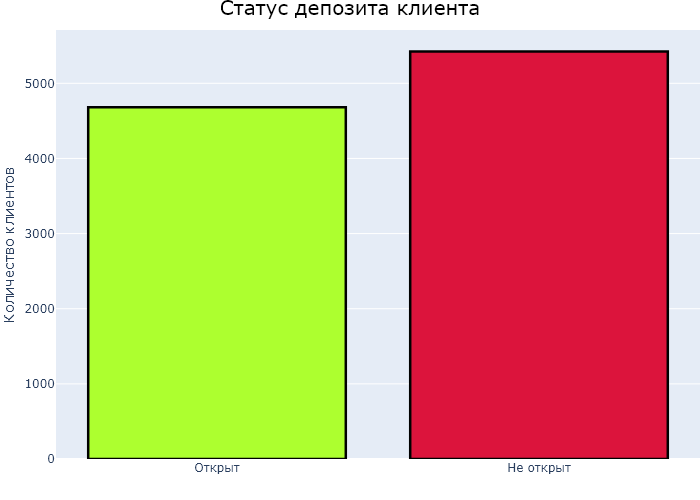

In [205]:
# Построение графика

fig = px.histogram(df_c,
                   x='deposit',
                   width=700,
                   height=500,
                   color="deposit", 
                   color_discrete_sequence=['#adff2f', '#dc143c'] # заданные цвета для колонок
                   )

# Настройка осей графика:
fig.update_layout(
    # Название графика
    title=dict(
        text='Статус депозита клиента', # Название
        font=dict(size=20, color= "black"), # Шрифт, цвет названия
        x=0.5 # заголовок центруем
        ),
    # Название осей
    xaxis=dict(title = "",
        tickmode='array', # режим размещения делений
        tickvals=[1, 0], # значение делений на оси
        ticktext=['Не открыт', 'Открыт'] # текст отображаемый на делениях
    ),
    yaxis_title="Количество клиентов", # Название оси y
    yaxis_tickformat='.0f', # Формат отображение по оси y
    margin=dict(l=0, r=0, t=30, b=0),
    showlegend = False, # Убираем легенду
    bargap = 0.2 # Расстояние между колонок
    )


# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="Клиентов: %{y}<br>", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=2.5,       # Толщина линии колонки
    opacity=1            # Прозрачность колонки
)

# Для интерпретатора
# fig.show();

# Для github
fig.write_image("png/deposit.png", engine="kaleido")
display(Image(filename=f"png/deposit.png"))

<div class="alert alert-info">

В очищенных данных статус **депозита** практически сбалансирован

In [206]:
# Получим статистическую информацию по признакам:
df_c.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [207]:
# Создадим функцию построения графиков по количественным признакам
# для визуального восприятия информации:

def quant_fig(x, layout_name, xaxis_title):
    """Функция построения графиков для количественных переменных

    Args:
        x (_str_): Название колонки из Dataframe для расчёта моды и построения графика
        layout_name (_str_): Название графика
        xaxis_title (_str_): Название оси X
    """    
    # Вычисляем моду, это понадобится для выделение моды на графике
    mode = df_c[x].mode()[0]
    
    # Для большей красоты визуализации генерируем случайный цвет,
    # чтобы каждый график был новым цветом (генерируются три случайных числа в диапазоне от 0 до 255.
    # Затем эти числа вставляются в строку в формате RGB с помощью f-строки)
    random_color = f'rgb({random.randint(0, 255)}, ' \
                   f'{random.randint(0, 255)}, ' \
                   f'{random.randint(0, 255)})'
    
    # Строим график
    fig = px.histogram(
        df_c, # df
        x = x, # x
        marginal='box',
        nbins=100,
        width=1000,
        height=500,
        color_discrete_sequence=[random_color] # цветовая палитра
    )

    # Устанавливаем название графика, размеры текста и наименование осей:
    fig.update_layout(
        title={
            'text': f'Распределение {layout_name}',
            'y':0.97,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
        title_font={
            'size':18,
            'color':"black"
            },
        xaxis_title=f'{xaxis_title}',
        yaxis_title='Количество'
    )

    # Добавляем обводку колонок
    fig.update_traces(
        hoverinfo="all",
        hovertemplate=f'{xaxis_title}: %{{x}}<br> Количество: %{{y}}',
        marker_line_color='black',   # Цвет линии колонки
        marker_line_width=1.0,       # Толщина линии колонки
        opacity=0.9            # Прозрачность колонки
    )

    # Устанавливаем дополнительную линию моды на графике:
    fig.add_vline(
        x=mode,
        line_width=2, 
        line_color="black", 
        annotation_text=f"Мода распределения: {mode}",
        annotation_position='bottom left'
    )

    # Упростим чтение визуализации добавив "шпильки" на оси:
    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    
    
    # Для открытия на github
    # Сохраняем график с уникальным именем файла
    fig.write_image(f"png/figure_{x}.png", engine="kaleido")
    # Открываем и отображаем полученную картинку в интерпретаторе
    display(Image(filename=f"png/figure_{x}.png"))
    
    # Для интерпретатора
    # fig.show()

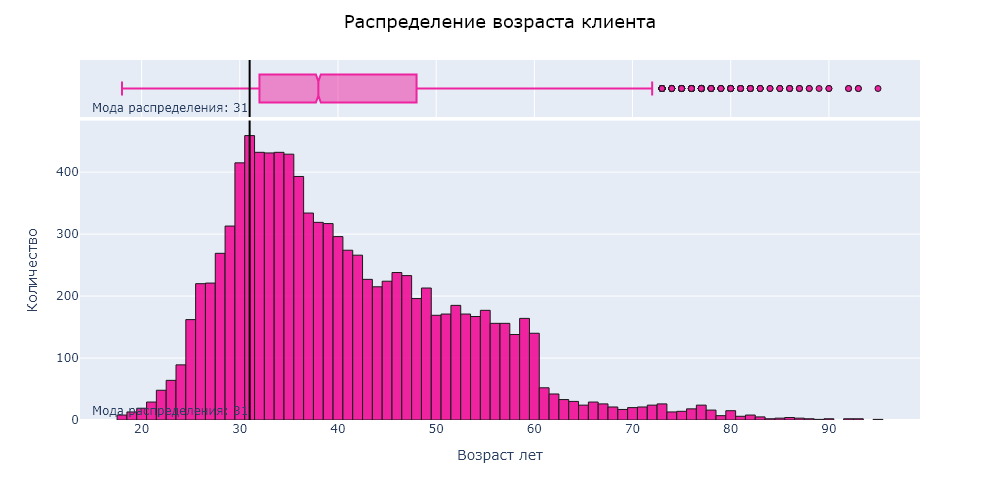

In [208]:
quant_fig('age', 'возраста клиента', 'Возраст лет')

<div class="alert alert-success">
Возраст клиентов находится в большом диапазоне, от 18 лет до 95. Чаще всего клиенты встречаются возрастом 35 лет.
 Так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет особо содержательной. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним, при дальнейшем исследовании так и сделаем, разделим на подгруппы возраст.

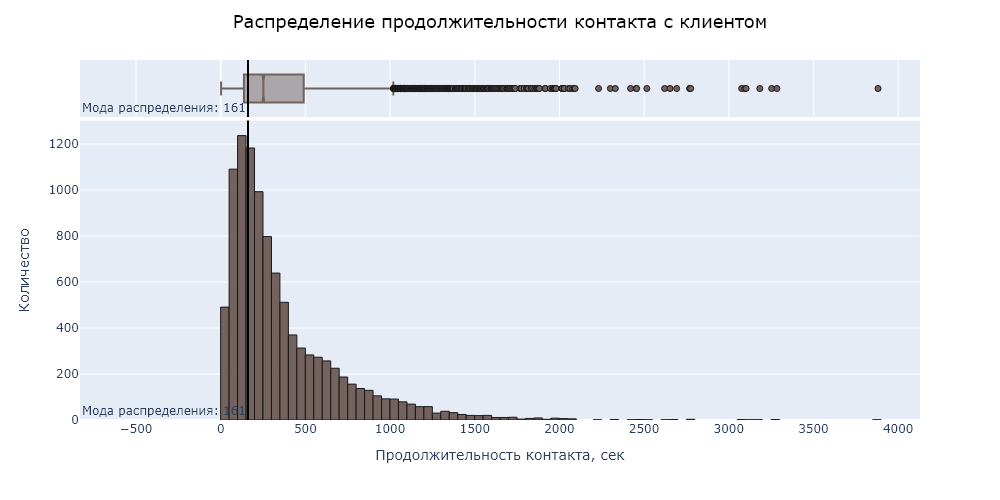

In [209]:
quant_fig('duration', 'продолжительности контакта с клиентом', 'Продолжительность контакта, сек')

<div class="alert alert-success">
Основная продолжительность контакта с клиентом находится в диапазоне от 50 до 300 сек.
Есть и аномальные значения где продолжительность контакта с клиентом более 30 минут (1800 сек), но сделаем допущение, что на практике возможны такие продолжительные контакты, и в случае обучения модели, может повлиять на окончательный результат, поэтому оставим все как есть 

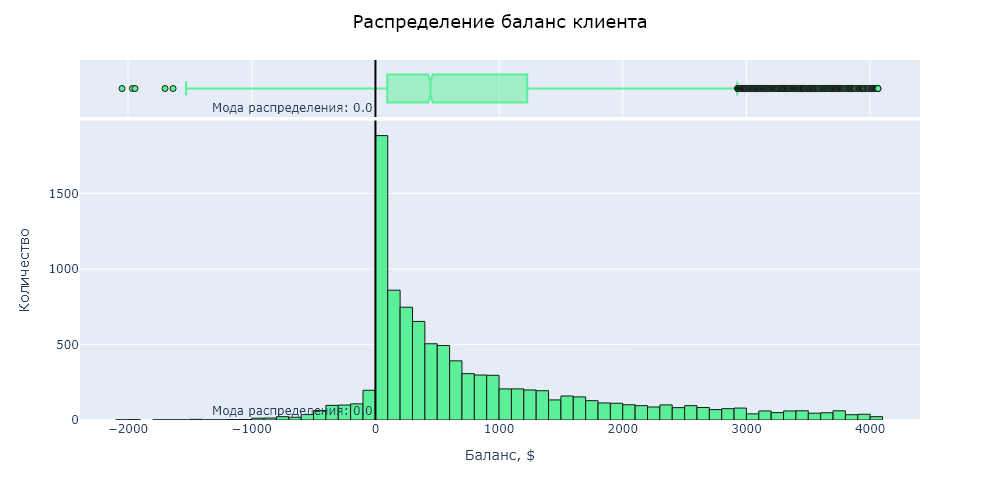

In [210]:
quant_fig('balance', 'баланс клиента', 'Баланс, $')

<div class="alert alert-success">
Основновная масса клиентов имеет баланс до 1000$. При этом 1884 клиента имеют околонулевой баланс. 0$ - является модальным значением. В среднем же у клиентов около 445$.
Есть и непонятные значение, где баланс ушел в минус, возможно какие-то долги или пени от банка к клиентам. 

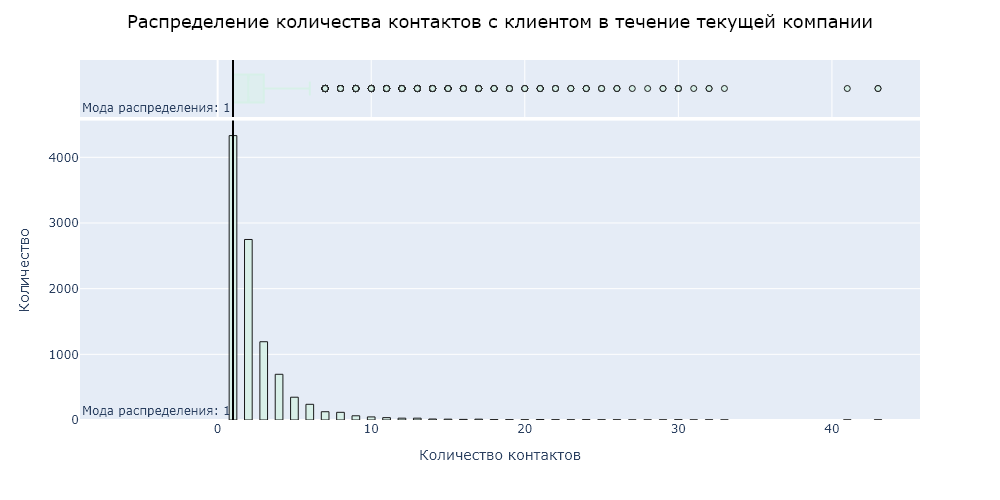

In [211]:
quant_fig('campaign', 'количества контактов с клиентом в течение текущей компании', 'Количество контактов')

<div class="alert alert-success">
Чаще всего с количество контактов с клиентами было 1 (оно и минимальное количество), максимально 43 - возможно это наши ребята с которыми были длительные разговоры.

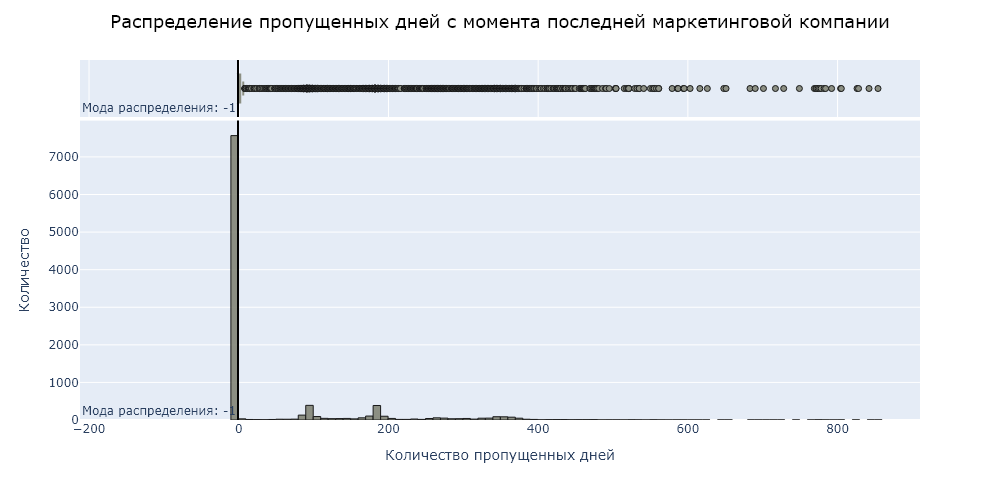

In [212]:
quant_fig('pdays', 'пропущенных дней с момента последней маркетинговой компании', 'Количество пропущенных дней')

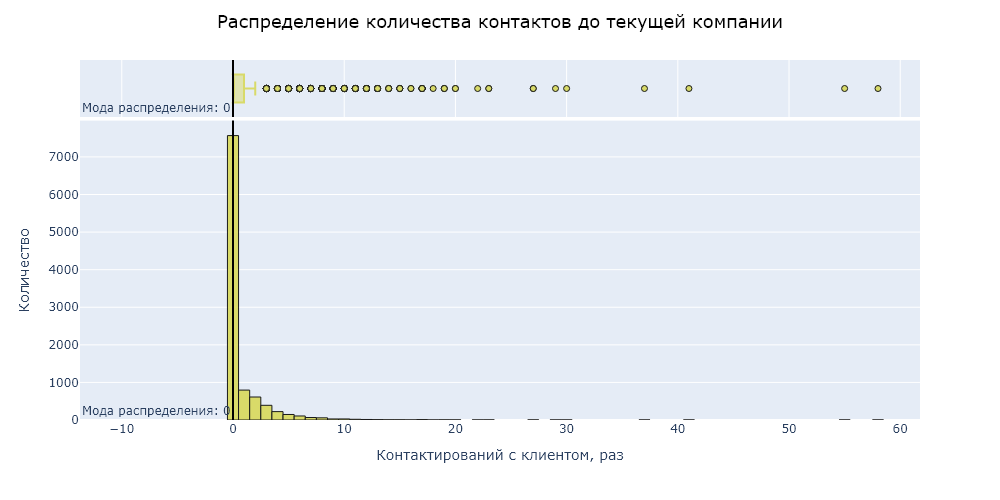

In [213]:
quant_fig('previous', 'количества контактов до текущей компании', 'Контактирований с клиентом, раз')

<div class="alert alert-success">
Распределение пропущенных дней с последней маркетинговой компании до контакта в текущей кампании и распределение количество контактов до текущей кампании - будут малоинформативны, так как очень большое количество клиентов будут иметь одинаковые значения

<div class="alert alert-info">

Перед изучением распределения целевой переменной по признакам, создадим новый признак, а именно преобразуем возраст клиентов.
В новой переменной будут находиться индикаторы принадлежности к одной из следующих категорий:
- **<30**;
- **30-40**;
- **40-50**;
- **50-60**;
- **60+**.

In [214]:
df_c['age_group'] = pd.cut(df_c.age, [0,30,40,50,60,9999],
                            labels = ['<30','30-40','40-50','50-60','60+'])

<div class="alert alert-info"> 

А теперь создадим функцию для визуального изучения распределения целевой переменной

In [215]:
def cat_graph(x):
    """Построение графиков распределения целевой переменной по признакам

    Args:
        x (_str_): интересующий нас признак
    """    
    df_pivot = df_c.pivot_table(index=x, # исследуемый признак
                                columns='deposit', # столбцы по которым разделяем признак
                                aggfunc='size' # параметр агрегации для подсчета вхождений
                                )

    color_sequence = ['#e32636', '#177245'] # Цветовая палитра 
    
    fig = px.bar(
        df_pivot,
        x=df_pivot.columns,
        y=df_pivot.index,
        width=1000,
        height=500,
        barmode="group",
        color_discrete_sequence=color_sequence,
        title=f'Распределение открытия депозита (признак {x})',
    )

    fig.update_layout(
        title={
            'text': f'Распределение открытия депозита (признак {x})',
            'y':0.97,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
        title_font={
            'size':18,
            'color':"black"
            },
        xaxis_title="Количество",
        yaxis_title="Категории",
        yaxis_tickformat=',.2f',
        margin=dict(l=0, r=0, t=30, b=0),
        legend_title = 'Статус открытия депозита',
    )
        
    fig.update_traces(
        hoverinfo="all",
        hovertemplate=f'Количество: %{{x}}',
        marker_line_color='black',   # Цвет линии колонки
        marker_line_width=1.0,       # Толщина линии колонки
        opacity=0.7           # Прозрачность колонки
    )     

    # Для интепретатора    
    # fig.show()
    
    # Для гихаба
    # Сохраняем график с уникальным именем файла
    fig.write_image(f"png/figure_{x}.png", engine="kaleido")
    display(Image(filename=f"png/figure_{x}.png"))


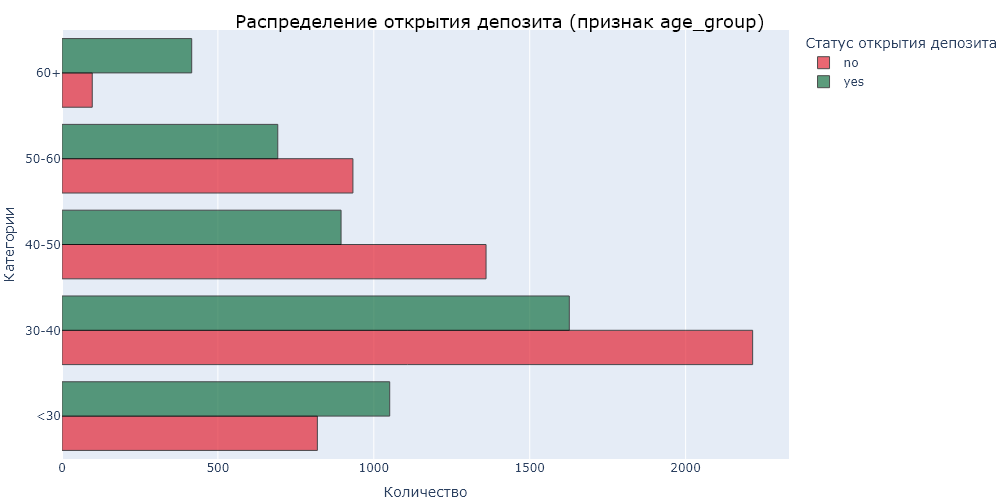

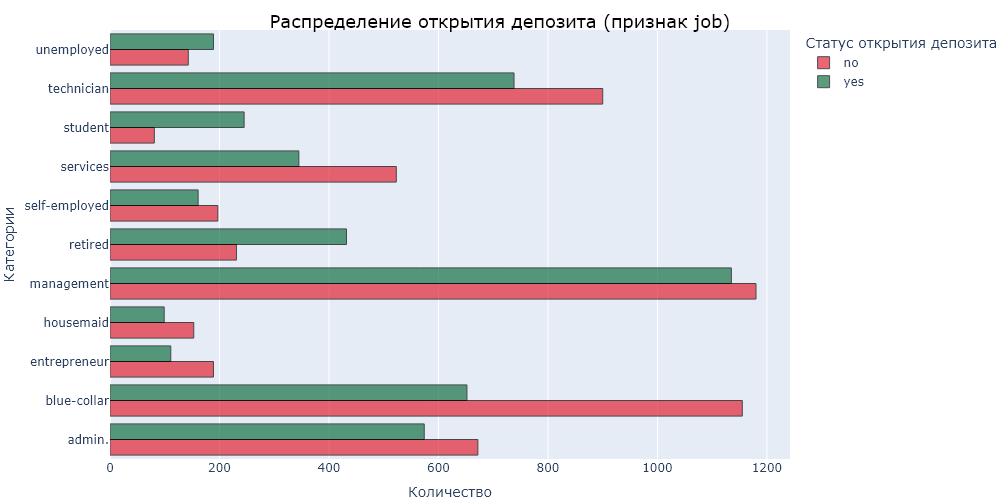

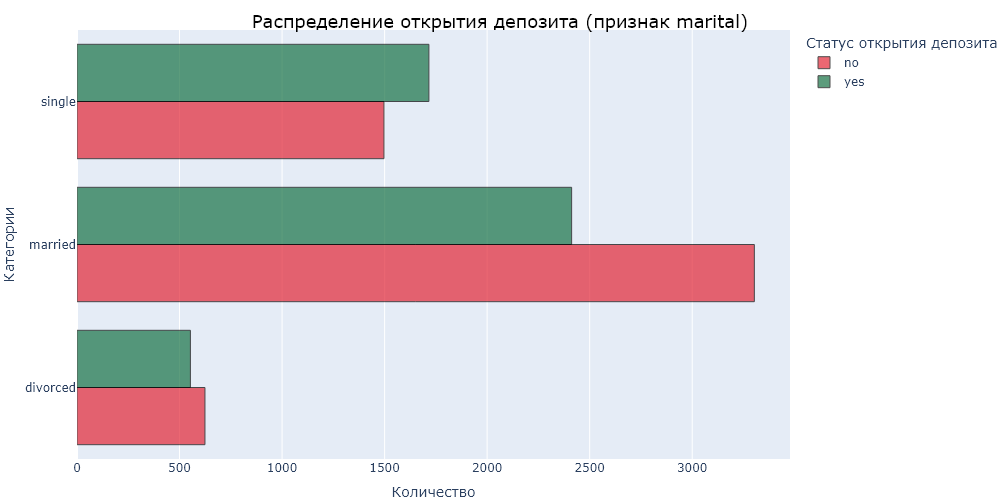

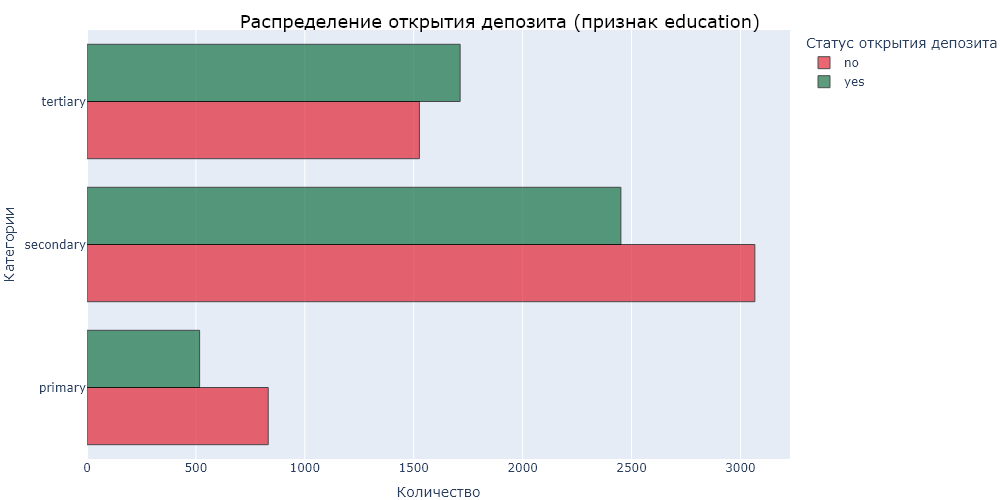

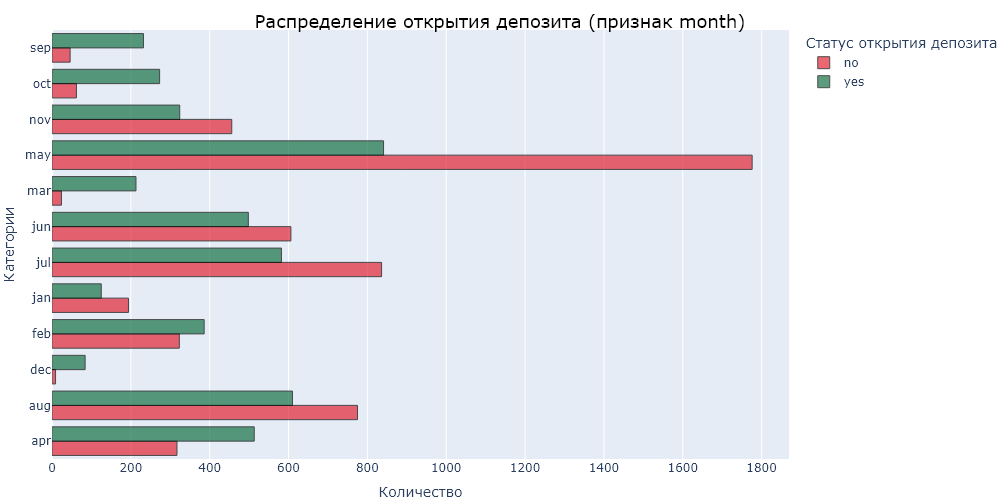

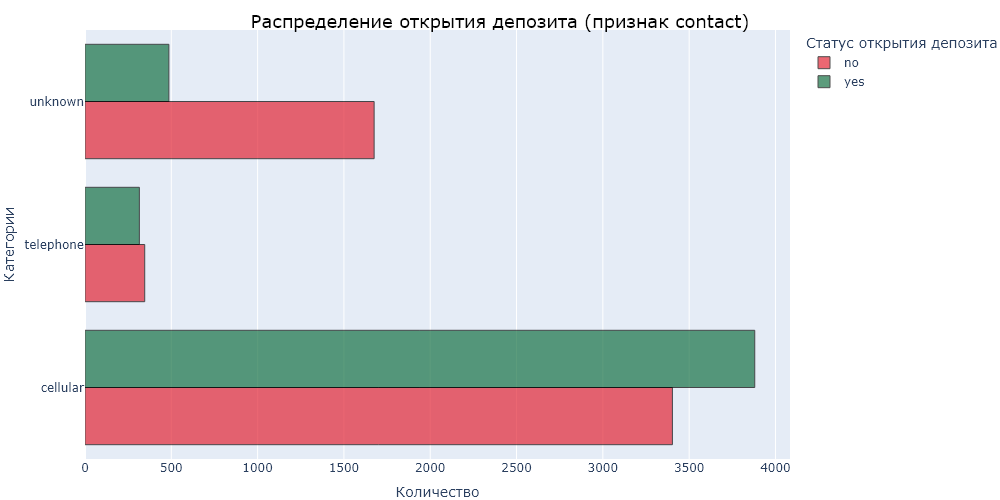

In [216]:
# Создадим список с интересующими нас колонками
column_list = ['age_group', 'job', 'marital', 'education', 'month', 'contact']

# Строим графики
for col in column_list:
    cat_graph(col)

<div class="alert alert-success">

Небольшие сводки по распределению целевой переменной по признакам:
1. Возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения это наши две стороны клиенты до 30, и после 60. Остальные чаще отказывают.
1. Больше всего клиентами банка явлются `management`, `technician`, `blue-collar` -  но вероятность открытия депозита у них чаще нет, чем да. Клиенты занимающие должности: `unemployed`, `retired` и `student` - чаще других открывают депозит.
1. Холостые клиенты открывают чаще депозит, клиенты находящиейся в браке напротив, менее склоны открывать.
1. Клиенты с вышим образованием имеют положительную тенденцию к открытию депозита в отличие с клиентами с начальным или средним образованием
1. В мае самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Стоит обратить внимание, что осенью, в конце зимы и начале весны клиенты больше склонны к открытию депозита. Возможно потому-что с начала отпусков, которые чаще всего проходят летом - не стремятся открывать депозитный счет, так как лишних финансов нет
1. Тип контакта с клиентом показал 3 категории, среди которых присутствует unknown - предлагается его заполнить. Важно учитывать, что заполнение признака "contact" может повлиять на качество и интерпретируемость модели. Если признак "concact" является важным предиктором и имеет сильное влияние на целевую переменную, то рекомендуется использовать метод заполнения, который сохраняет распределение известных значений. Например, заполнение модой может быть предпочтительным, чтобы сохранить наиболее часто встречающееся значение. Если признак "concact" не является критически важным или не имеет сильного влияния на целевую переменную, то можно использовать любой из предложенных методов заполнения. В этом случае, выбор метода может зависеть от предпочтений и удобства использования. На данном этапе сложно сказать, насколько этот признак является важным, поэтому несмотря на то, что хотелось его заполнить случайными значениями из этого признака, предпочтение отдадим модальному значению

In [217]:
# заменим на модальное значение
# modal_contact = df_c['contact'].mode()[0]
# df_c['contact'] = df_c['contact'].replace('unknown', modal_contact)

In [218]:
# Взглянем что получилось
# cat_graph('contact')

<div class="alert alert-danger fade show">

Проведенная замена unknown признака contact на модальное, в дальнейшем исследовании показала мультиколлениарность признака contact telephone. Принято решение оставить признак в начальном виде. 

### Задание 11

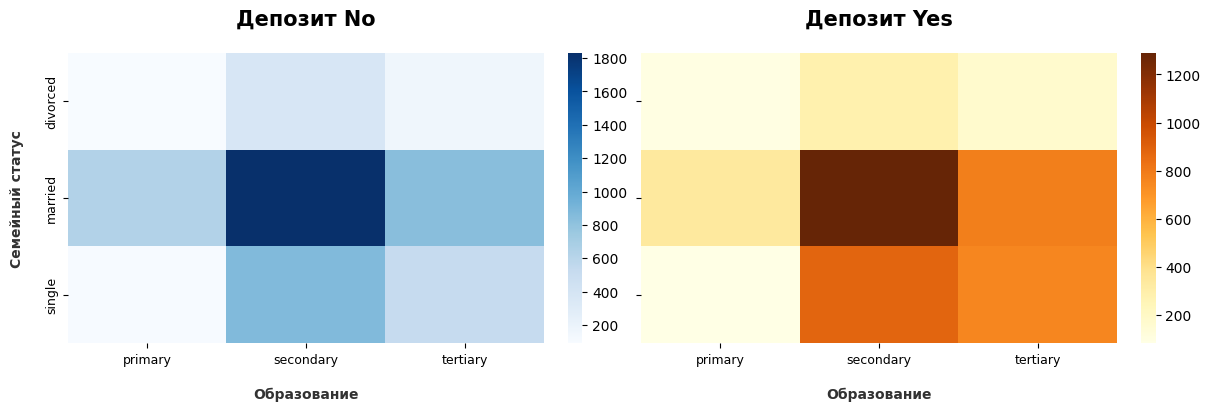

In [219]:
# построем сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Создаем 2 новых df с условиями статуса deposit
m_e_deposit_n = df_c[df_c['deposit'] == 'no'][['marital','education']]
m_e_deposit_y = df_c[df_c['deposit'] == 'yes'][['marital','education']]

# Создаем две кросс таблицы
no_deposit = pd.crosstab(m_e_deposit_n['marital'], m_e_deposit_n['education'])
yes_deposit = pd.crosstab(m_e_deposit_y['marital'], m_e_deposit_y['education'])


# Строим тепловые карты
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True, sharey=True)

# sns.heatmap(кросс таблица, ось(график), цвет);
sns.heatmap(no_deposit, ax = ax1, cmap="Blues");
sns.heatmap(yes_deposit, ax = ax2, cmap="YlOrBr");

# ax1.set_xlabel('Название оси, размер шрифта, расстояние от оси)
        #fontdict = {цвет : '#323232', 'насыщенность текста' : 'bold'})
ax1.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})
ax1.set_ylabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})

# ax1.set_title('Название графика', размер шрифта, 'насыщенность текста' : 'bold', расстояние от графика)
ax1.set_title('Депозит No', fontsize=15, fontweight = 'bold', pad = 20)

ax2.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})
ax2.set_title('Депозит Yes', fontsize=15, fontweight = 'bold', pad = 20)
ax2.set_ylabel('')

ax1.tick_params(axis='both', which='major', labelsize=9);
ax2.tick_params(axis='both', which='major', labelsize=9);

<div class="alert alert-success">

Пересечение married secondary категорий является самым многочисленным как и на открытие так и на закрытие депозита.

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 3: преобразование данных

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info"> 

Перед тем как перейти к построению модели:
- Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо **преобразовать категориальные признаки** в более удобный формат.
- Надо **отобрать признаки**, которые мы будем использовать **для обучения модели**.
- Необходимо **масштабировать и трансформировать** некоторые **признаки** для того, чтобы улучшить качество модели.

In [220]:
# Создание экземпляра LabelEncoder
LE=LabelEncoder()
df_c['education'] = LE.fit_transform(df_c['education'])
df_c['age_group'] = LE.fit_transform(df_c['age_group'])

In [221]:
# Создание экземпляра LabelBinarizer для бинарных признаков
LB = LabelBinarizer()
df_c['deposit'] = LB.fit_transform(df_c['deposit'])
df_c['default'] = LB.fit_transform(df_c['default'])
df_c['housing'] = LB.fit_transform(df_c['housing'])
df_c['loan'] = LB.fit_transform(df_c['loan'])

<div class="alert alert-info"> 

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. 

In [222]:
df_x = pd.get_dummies(df_c, columns=['job','marital','contact','month','poutcome'])

<div class="alert alert-info"> 

Построем корреляционную матрицу и оценим данные на предмет наличия **мультиколлинеарности**

In [223]:
def corr_heatmap(data, title, method):
    """  Построения корреляционной диаграммы
    Args:
        data (_data_): подготовленный датафрейм
        title (_str_): Название графика
        method (_str_): Метод
    """    
 
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data.corr(method=method).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                annot_kws={"fontsize":6}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

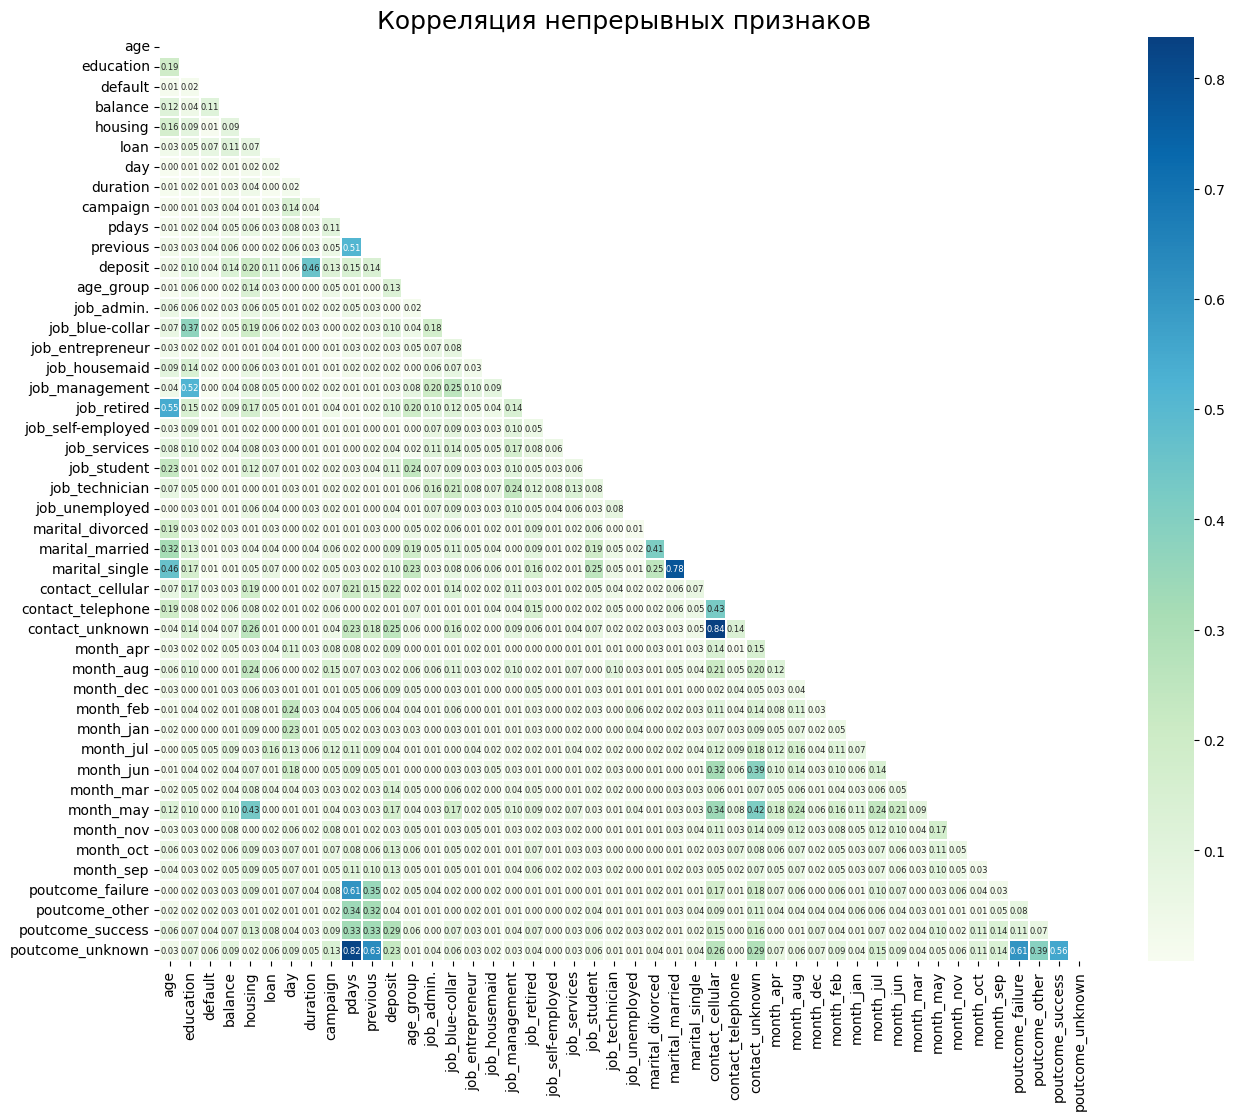

In [224]:
#строим диаграмму для непрерывных признаков:
corr_heatmap(df_x, 'Корреляция непрерывных признаков', 'pearson');

In [225]:
corr = df_x.drop(columns=['age_group']).corr().values
np.fill_diagonal(corr,0)

print(f"Максимальное значение корреляции:{abs(corr).max().round(2)}")

Максимальное значение корреляции:0.84


Text(0.5, 1.0, 'Корреляционная матрица')

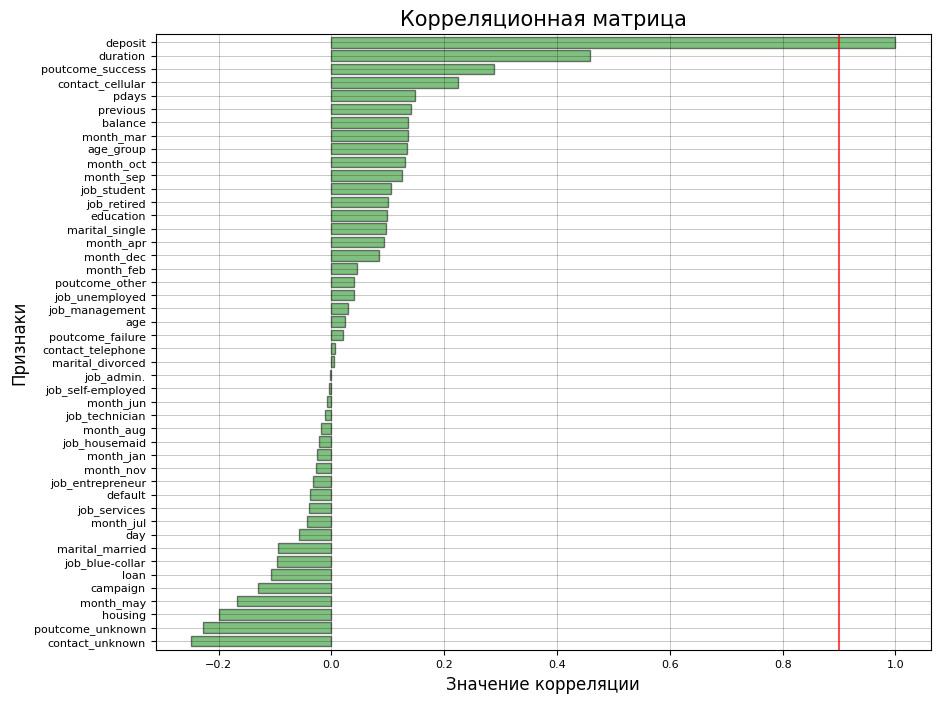

In [226]:
# вычисляем матрцу
corr = df_x.corr()

# Cтроим график
plt.figure(figsize=(10, 8))

# corr[col].sort_values().plot.barh(color=цвет, edgecolor=цвет обводки,
# linewidth=толщина обводки, width=ширина колонки, alpha=прозрачность колонки)
corr["deposit"].sort_values().plot.barh(color='green', edgecolor='black', linewidth=1, width=0.8, alpha=0.5)

# Названия осей и визуальные вид их
plt.xlabel("Значение корреляции", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.grid(Присутствие сетки на графике(True or False), linestyle=вид,  linewidth=толщина линии, 
# alpha=прозрачность сетки, color=цвет)
plt.grid(True, linestyle='-',  linewidth=0.5, alpha=0.3, color='black')

# Задаем отметку линии мультиколлениарности
# plt.axvline(ось=значение, color=цвет, linestyle=вид, alpha=прозрачность)
plt.axvline(x=0.9, color='red', linestyle='-', alpha=0.7)

plt.title("Корреляционная матрица", fontsize=15)

<div class="alert alert-success">

Будем считать достаточно сильной корреляцию не менее 0.9. Поэтому можно сделать вывод, что среди признаков мультиколлинеарность отсутсвует.

В наибольшей степени коррелирующие с целевой переменной признаки, по убыванию силы линейной взаимосвязи это - `duration`, `poutcome_success`,`contact_cellular`.

<div class="alert alert-info"> 

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

**Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.**

In [227]:
X = df_x.drop(['deposit'], axis=1)
y = df_x['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print(colored('Определим соотношения классов в каждом из наборов данных:', 'green'))
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')
print('\n')
print(colored('Размеры выборок:', 'green'))
print(f'X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'X_test={X_test.shape}, y_test={y_test.shape[0]}')

Определим соотношения классов в каждом из наборов данных:
Train:
deposit
0    0.53678
1    0.46322
Name: proportion, dtype: float64
Valid:
deposit
0    0.536732
1    0.463268
Name: proportion, dtype: float64


Размеры выборок:
X_train=(6770, 45), y_train=6770
X_test=(3335, 45), y_test=3335


<div class="alert alert-info"> 

Теперь в каждом из наборов данных одинаковые соотношения классов — 54/46. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

<div class="alert alert-info"> 


На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Предлагается оставить лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.



In [228]:
# Создаем экземпляр SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)

# Применяем SelectKBest к данным X и y
selector.fit(X_train, y_train)

selectKBest_columns = list(selector.get_feature_names_out())
selectKBest_columns_list = '\n'.join(selectKBest_columns)
print(f"Выбранные наилучшие признаки для модели:\n{selectKBest_columns_list}")

Выбранные наилучшие признаки для модели:
balance
housing
duration
campaign
pdays
previous
age_group
contact_cellular
contact_unknown
month_mar
month_may
month_oct
month_sep
poutcome_success
poutcome_unknown


<div class="alert alert-info">

В конце масштабируем и трансформируем отобранные признаки для улучшения результатов модели 

In [229]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train[selectKBest_columns])                           
X_train_scaled = scaler.transform(X_train[selectKBest_columns])    
X_test_scaled = scaler.transform(X_test[selectKBest_columns])      

In [230]:
X_test_scaled[:, 0].mean().round(2)

0.47

<div class="alert alert-success">

Признаки преобразованы, отобраны и выполненно их масштабирование. Теперь данные готовы для дальнеших решений поставленных целей

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

### Задание 1

In [231]:
# Создадим сборщик результатов обучения:
results_learn = []

In [232]:
def o_metric(object_m, model_name):
    """Функция вывода тренировочных и тестовых данных

    Args:
        object_m (object_m): Объект класса,
        model_name (str) : Название модели,
    """

    start_time = time.time()  # Записываем текущее время перед обучением модели
    object_m.fit(X_train_scaled, y_train)

    print(colored(f'\n{model_name} результаты accuracy_score:', 'light_red'))
    y_train_pred = object_m.predict(X_train_scaled)
    m_train = round(metrics.accuracy_score(y_train, y_train_pred),3)
    print(colored(f"- Тренировочный набор: {m_train:.3f}", 'cyan'))
    y_test_pred = object_m.predict(X_test_scaled)
    m_test = round(metrics.accuracy_score(y_test, y_test_pred),3)
    print(colored(f"- Тестовый набор: {m_test:.3f}", 'cyan'))  

    end_time = time.time()  # Записываем текущее время после получения результатов
    execution_time = round(end_time - start_time, 3)  # Вычисляем время выполнения
    
    
    print(colored(f'\nВремя обучения (секунд): {execution_time:.2f}', 'yellow'))

    # Сохраняем все данные
    results_learn.append({'model_name': model_name,
                          'train': m_train,
                          'test': m_test,
                          'time': execution_time,})

In [233]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучение через функцию:
o_metric(log_reg, 'LogisticRegression')

# log_reg.fit(X_train_scaled, y_train)
# y_pred = log_reg.predict(X_test_scaled)
# print(f"Accuracy для тестовой выборки:{round(metrics.accuracy_score(y_test, y_pred),2)}")


LogisticRegression результаты accuracy_score:
- Тренировочный набор: 0.824
- Тестовый набор: 0.808

Время обучения (секунд): 0.02


### Задания 2,3,4

In [234]:
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)

# Обучение через функцию:
o_metric(dt_clf_2d, 'DecisionTreeClassifier')


# обучите решающие деревья, настройте максимальную глубину
# dt_clf_2d = tree.DecisionTreeClassifier(
#     criterion='entropy', #критерий информативности 
#     random_state=42 #генератор случайных чисел
# )
# dt_clf_2d.fit(X_train_scaled, y_train)

# y_train_pred = dt_clf_2d.predict(X_train_scaled)
# y_pred = dt_clf_2d.predict(X_test_scaled)

# print(f"Accuracy для трейн выборки:{round(metrics.accuracy_score(y_train, y_train_pred),2)}")
# print(f"Accuracy для тестовой выборки:{round(metrics.accuracy_score(y_test, y_pred),2)}")



DecisionTreeClassifier результаты accuracy_score:
- Тренировочный набор: 1.000
- Тестовый набор: 0.749

Время обучения (секунд): 0.03


<div class="alert alert-info">

Исходя из результатов Accuracy можем смело заявлять, что у нас переобучение.

Проверим, как будет меняться значение accuracy для train и test выборок при глубине дерева в диапазоне от 1 до 10

In [235]:
max_depth_list = np.linspace(1, 10, 10)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for max_depth in max_depth_list:
  log_d_tree = tree.DecisionTreeClassifier(
      criterion='entropy', 
      random_state=42,
      max_depth=int(max_depth) 
  )
  log_d_tree.fit(X_train_scaled, y_train)

  y_train_pred = log_d_tree.predict(X_train_scaled)
  y_pred = log_d_tree.predict(X_test_scaled)

  train_scores.append(round(metrics.accuracy_score(y_train, y_train_pred), 2))
  test_scores.append(round(metrics.accuracy_score(y_test, y_pred), 2))

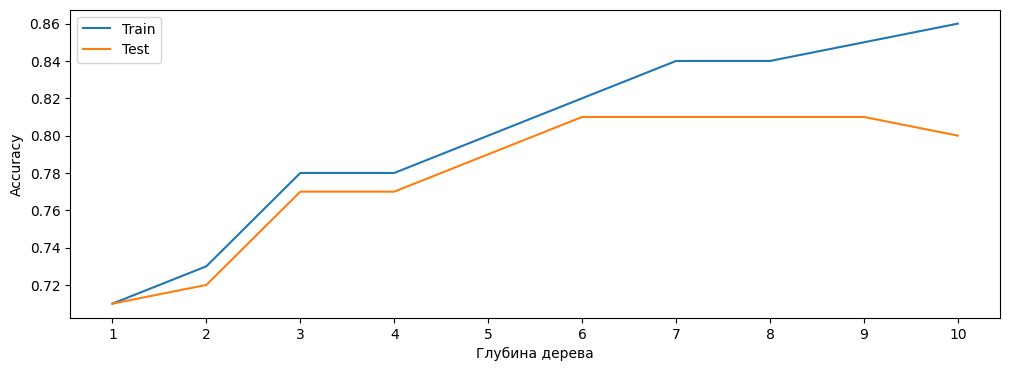

In [236]:
#Визуализируем изменение accuracy в зависимости от параметра грубина дерева для test и train выборок
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depth_list, train_scores, label='Train') 
ax.plot(max_depth_list, test_scores, label='Test') 
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy') 
ax.set_xticks(max_depth_list) 
ax.legend(); 

<div class="alert alert-info">

Максимально сбалансированный результат с наивысшым значением accuracy наблюдается при глубине дерева равным 6-ти

In [237]:
dt_clf_2d_best_depth = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=6, #максимальная глубина
    random_state=42 #генератор случайных чисел
)

o_metric(dt_clf_2d_best_depth, 'DecisionTreeClassifier_best')\
    
# dt_clf_2d = tree.DecisionTreeClassifier(
#     criterion='entropy', #критерий информативности 
#     max_depth=6, #максимальная глубина
#     random_state=42 #генератор случайных чисел
# )
# dt_clf_2d.fit(X_train_scaled, y_train)

# y_train_pred = dt_clf_2d.predict(X_train_scaled)
# y_pred = dt_clf_2d.predict(X_test_scaled)

# print(f"Accuracy для трейн выборки:{round(metrics.accuracy_score(y_train, y_train_pred),2)}")
# print(f"Accuracy для тестовой выборки:{round(metrics.accuracy_score(y_test, y_pred),2)}")


DecisionTreeClassifier_best результаты accuracy_score:
- Тренировочный набор: 0.818
- Тестовый набор: 0.807

Время обучения (секунд): 0.02


<div class="alert alert-info">

Подберем оптимальные параметры с помощью gridsearch

In [238]:
# параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1
)

o_metric(grid_search, 'GridSearchCV LogisticRegression')

# %time grid_search.fit(X_train_scaled, y_train) 

# print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

# y_test_pred = grid_search.predict(X_test_scaled)
# metrics_test = round(metrics.f1_score(y_test, y_test_pred), 2)
# print(f"Наилучшее значение f1: {metrics_test}")

# print(f"Accuracy для трейн выборки:{round(metrics.accuracy_score(y_train, y_train_pred),2)}")
# print(f"Accuracy для тестовой выборки:{round(metrics.accuracy_score(y_test, y_test_pred),2)}")


GridSearchCV LogisticRegression результаты accuracy_score:
- Тренировочный набор: 0.838
- Тестовый набор: 0.812

Время обучения (секунд): 2.28


<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info">

Обучим данные случайному лесу

In [239]:
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf=5,
    max_depth=10, #максимальная глубина дерева
    # max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)

o_metric(rf_clf_2d, 'RandomForestClassifier')

# #Обучаем модель 
# rf_clf_2d.fit(X_train_scaled, y_train)
 
# # train_scores.append(round(metrics.accuracy_score(y_train, y_train_pred),2))
# # test_scores.append(round(metrics.accuracy_score(y_test, y_pred),2))

# #Делаем предсказание класса
# y_pred = rf_clf_2d.predict(X_test_scaled)
# #Выводим отчёт о метриках
# # print(metrics.classification_report(y_test, y_pred))

# print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
# #Рассчитываем precision
# # print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
# #Рассчитываем recall
# print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
# #Рассчитываем F1-меру
# print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))


RandomForestClassifier результаты accuracy_score:
- Тренировочный набор: 0.857
- Тестовый набор: 0.827

Время обучения (секунд): 0.41


<div class="alert alert-info">

Используем для классификации градиентный бустинг

In [240]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

o_metric(gb, 'GradientBoostingClassifier')

# gb.fit(X_train_scaled, y_train)

# y_pred = gb.predict(X_test_scaled)

# print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
# #Рассчитываем precision
# # print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
# #Рассчитываем recall
# print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
# #Рассчитываем F1-меру
# print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))


GradientBoostingClassifier результаты accuracy_score:
- Тренировочный набор: 0.887
- Тестовый набор: 0.826

Время обучения (секунд): 3.13


<div class="alert alert-info">

Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

In [241]:
pd.concat([pd.Series(selectKBest_columns), pd.Series(gb.feature_importances_)], axis=1).\
  set_axis(['feature','importance'], axis = 1).sort_values(by='importance', ascending=False)

,feature,importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582
0,balance,0.057952
4,pdays,0.055121
1,housing,0.047725
6,age_group,0.039902
9,month_mar,0.027819
11,month_oct,0.019880
10,month_may,0.015245


<div class="alert alert-info">

Объединим алгоритмы с помощью стекинга 

In [242]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

o_metric(stack, 'StackingClassifier')


# stack.fit(X_train_scaled, y_train)
# y_pred = stack.predict(X_test_scaled)

# # y_pred = reg.predict(X_test_scaled)
# # print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
# # #Рассчитываем precision
# print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
# # #Рассчитываем recall
# # print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
# # #Рассчитываем F1-меру
# # print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))


StackingClassifier результаты accuracy_score:
- Тренировочный набор: 0.869
- Тестовый набор: 0.824

Время обучения (секунд): 16.61


<div class="alert alert-info">

Реализуем оптимизацию гиперпараметров с помощью Optuna

In [243]:
def optuna_func(trial):
  """Функция для оптимизации гипперпараметров

  Args:
      trial : предложение трех гипперпараметров

  """  
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train) 
  score = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

  return score


In [244]:
study_ranFor_opt = optuna.create_study(study_name="RandomForestClassifier Optuna Optimization", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_ranFor_opt.optimize(optuna_func, n_trials=10)

[I 2024-07-17 23:02:17,520] A new study created in memory with name: RandomForestClassifier Optuna Optimization
[I 2024-07-17 23:02:18,026] Trial 0 finished with value: 0.8257871064467767 and parameters: {'n_estimators': 118, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8257871064467767.
[I 2024-07-17 23:02:18,462] Trial 1 finished with value: 0.8293853073463269 and parameters: {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8293853073463269.
[I 2024-07-17 23:02:18,912] Trial 2 finished with value: 0.8281859070464768 and parameters: {'n_estimators': 113, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8293853073463269.
[I 2024-07-17 23:02:19,377] Trial 3 finished with value: 0.8254872563718141 and parameters: {'n_estimators': 112, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8293853073463269.
[I 2024-07-17 23:02:20,040] Trial 4 finished with value: 0.8272863568215892 

In [245]:
optuna = ensemble.RandomForestClassifier(n_estimators=study_ranFor_opt.best_params['n_estimators'],
                                        max_depth=study_ranFor_opt.best_params['max_depth'],
                                        min_samples_leaf=study_ranFor_opt.best_params['min_samples_leaf'],
                                        random_state=42)

In [246]:
o_metric(optuna, "RandomForestClassifier Optuna Optimization")


RandomForestClassifier Optuna Optimization результаты accuracy_score:
- Тренировочный набор: 0.908
- Тестовый набор: 0.831

Время обучения (секунд): 0.62


<div class="alert alert-info">

Визуализация оптимизации optuna

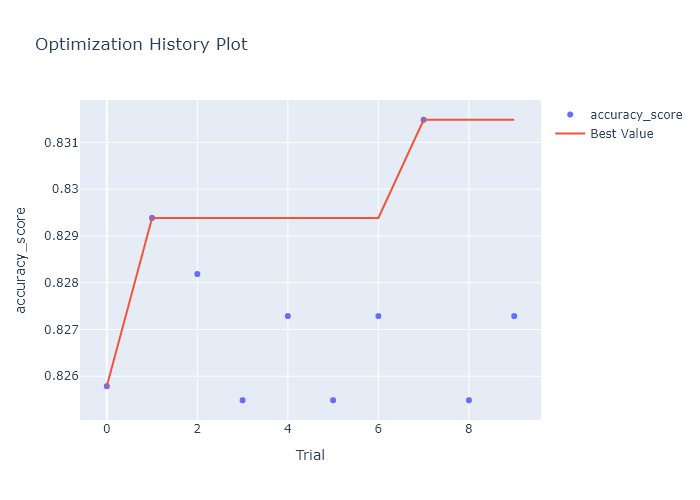

In [247]:
fig = vis.plot_optimization_history(study_ranFor_opt, target_name="accuracy_score")
fig.write_image("png/plot_optimization_history.png", engine="kaleido")

# Отображение графика на GITHUB
display(Image(filename="png/plot_optimization_history.png"))


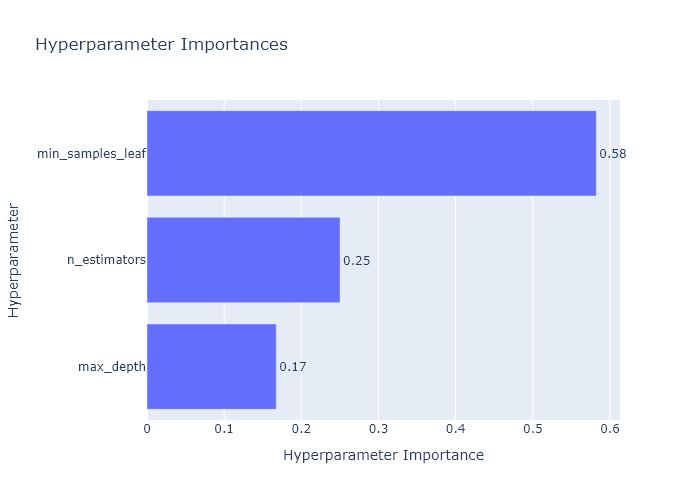

In [248]:
fig_ppi= vis.plot_param_importances(study_ranFor_opt, target_name="accuracy_score")

fig_ppi.write_image("png/plot_param_importances.png", engine="kaleido")

# Отображение графика на GITHUB
display(Image(filename="png/plot_param_importances.png"))

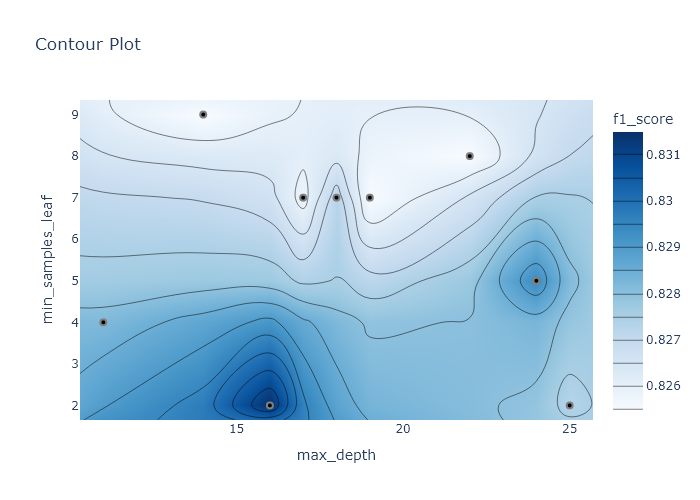

In [249]:
fig_pc = vis.plot_contour(study_ranFor_opt, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")

# Сохранение графика в файл
fig_pc.write_image("png/plot_contour.png", engine="kaleido")

# Отображение графика на GITHUB
display(Image(filename="png/plot_contour.png"))

<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Создадим DataFrame из полученных результатов, визуализируем и подытожим полученные результаты</span>

In [250]:
# Создадим датафрейм
results_learn = pd.DataFrame(results_learn)
# Добавим процетную разницу между train и test
results_learn['percent'] = round(((results_learn['train'] - results_learn['test']) / results_learn['train'])*100,2)
# Отсортируем по процентам:
df_sorted = results_learn.sort_values(by='percent')
df_sorted

,model_name,train,test,time,percent
2,DecisionTreeClassifier_best,0.818,0.807,0.016,1.34
0,LogisticRegression,0.824,0.808,0.023,1.94
3,GridSearchCV LogisticRegression,0.838,0.812,2.280,3.10
4,RandomForestClassifier,0.857,0.827,0.414,3.50
6,StackingClassifier,0.869,0.824,16.611,5.18
5,GradientBoostingClassifier,0.887,0.826,3.127,6.88
7,RandomForestClassifier Optuna Optimization,0.908,0.831,0.618,8.48
1,DecisionTreeClassifier,1.000,0.749,0.034,25.10


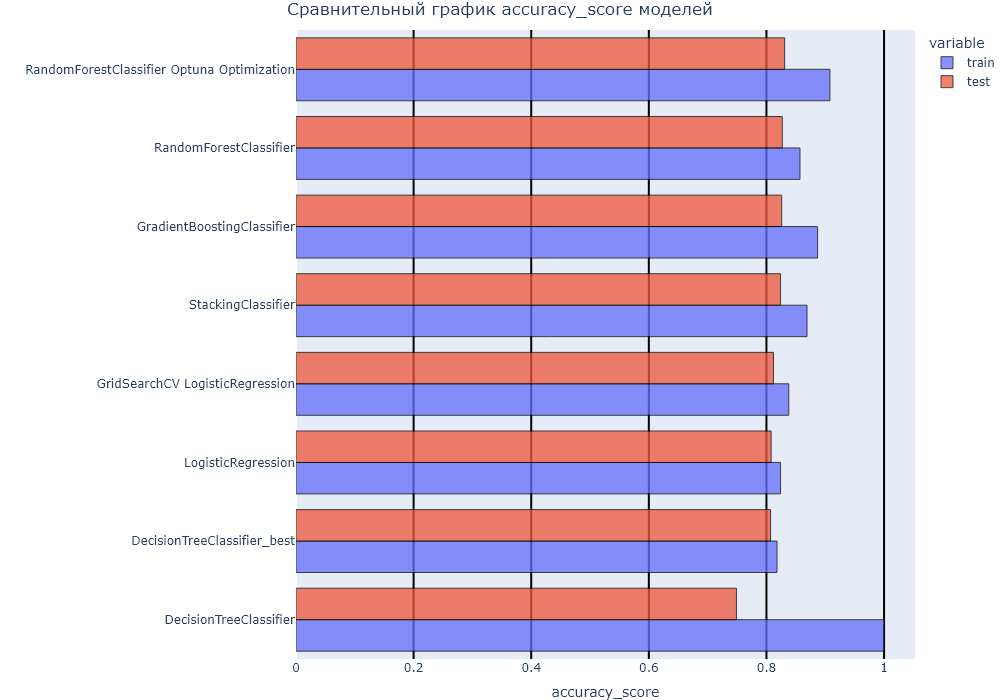

In [251]:
#Отсортируем данные для лучшей наглядности
result_test = results_learn.sort_values(by='test')

# Построение графика
fig = px.bar(result_test,
             y='model_name',
             x=['train', 'test'],
             barmode='group',
             title = 'Сравнительный график accuracy_score моделей',
             width=1000,
             height=700)

# Настройка осей графика:
fig.update_layout(
    title = dict(x = .5, xanchor = "center"),
    xaxis_title = "accuracy_score",
    yaxis_title="",
    margin=dict(l=0, r=0, t=30, b=0)
    )

# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="accuracy_score: %{x}", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=1.0,       # Толщина линии колонки
    opacity=0.75            # Прозрачность колонки
)

# Добавление сетки на график для улучшения визуального восприятия информации
fig.update_xaxes(showgrid=True, gridwidth=2, gridcolor='black')
# fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='black')

# Отображение графика
# fig.show()
fig.write_image("png/result_test.png", engine="kaleido")
display(Image(filename=f"png/result_test.png"))

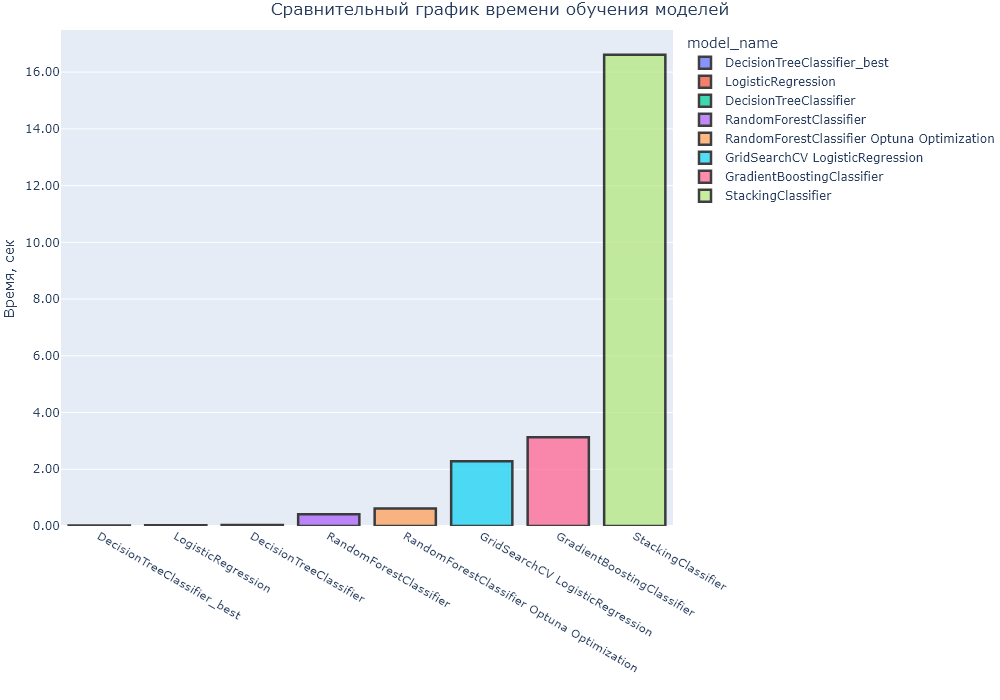

In [252]:
#Отсортируем данные для лучшей наглядности
result_time = results_learn.sort_values(by='time')

# Строим график
fig = px.bar(
    result_time,
    x = 'model_name',
    y = 'time',
    title = 'Сравнительный график времени обучения моделей',
    color = 'model_name',
    width=1000,
    height=700
)

# Настройка осей графика:
fig.update_layout(
    title = dict(x = .5, xanchor = "center"),
    xaxis_title = "",
    yaxis_title="Время, сек",
    yaxis_tickformat=',.2f',
    margin=dict(l=0, r=0, t=30, b=0)
    )

# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="Время обучения: %{y} сек", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=2.5,       # Толщина линии колонки
    opacity=0.75            # Прозрачность колонки
)
# fig.show();
fig.write_image("png/result_time.png", engine="kaleido")
display(Image(filename=f"png/result_time.png"))

<div class="alert alert-success">

Максимальная точность accuracy_score показала модель RandomForestClassifier Optuna Optimization (accuracy_score = 0.830), а наименьший разброс между train и test наблюдается DecisionTreeClassifier_best (разница = 1.34 % , при этом точность на test = 0.807, что тоже является не плохим результатом).